# Supervised learning

For this investigation I have chosen the national weather data of the Netherlands. I will attempt to predict which environment factors have an influence on whether it is raining or not.

Data source: https://www.kaggle.com/dsloet/dutch-weather/

## Data preprocessing

The data collected primarily relates to wind force and direction, humidity, and sunlight. There is no field directly related to wheter it rained or not, so we will have to do some preprocessing.

In [168]:
import pandas as pd
import numpy as np
from subprocess import call
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

with open('./input.csv', 'r') as file_handle:
    df = pd.read_csv(file_handle)

Our data is well behaved, with no NaN fields:

In [169]:
print(df.shape)
print(df.columns[df.isna().any()].tolist())
df.describe()

(4048, 40)
[]


,YYYYMMDD,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,FXXH,...,VVNH,VVX,VVXH,UG,UX,UXH,UN,UNH,TX,TXH
count,4.048000e+03,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,...,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000
mean,2.011604e+07,192.774457,30.097579,34.225049,52.465415,11.025692,16.912055,8.520504,100.390316,12.199358,...,10.125000,75.234684,13.190711,80.724061,95.287055,9.374259,63.235425,13.454792,147.661808,13.770751
std,3.220519e+04,91.073689,15.202191,13.988364,17.954416,5.514259,12.327392,8.496693,35.585343,5.583256,...,8.687769,8.487160,5.100734,9.577339,5.097673,8.855817,15.022828,3.904586,71.794548,3.701063
min,2.006070e+07,1.000000,0.000000,5.000000,10.000000,1.000000,0.000000,1.000000,20.000000,1.000000,...,1.000000,1.000000,1.000000,31.000000,43.000000,1.000000,19.000000,1.000000,-61.000000,1.000000
25%,2.009041e+07,131.000000,19.000000,24.000000,40.000000,9.000000,10.000000,1.000000,77.500000,10.000000,...,3.000000,71.000000,11.000000,75.000000,94.000000,2.000000,52.000000,12.000000,94.000000,13.000000
50%,2.012011e+07,210.000000,28.000000,32.000000,50.000000,11.000000,10.000000,4.000000,100.000000,12.000000,...,6.000000,78.000000,14.000000,82.000000,97.000000,5.000000,64.000000,14.000000,150.000000,14.000000
75%,2.014102e+07,252.250000,39.000000,42.000000,60.000000,14.000000,20.000000,18.000000,120.000000,15.000000,...,20.000000,81.000000,16.000000,88.000000,98.000000,20.000000,75.000000,15.000000,202.000000,15.000000
max,2.017073e+07,360.000000,106.000000,106.000000,140.000000,24.000000,90.000000,24.000000,280.000000,24.000000,...,24.000000,84.000000,24.000000,100.000000,100.000000,24.000000,99.000000,24.000000,357.000000,24.000000


### Labels

The field rain duration will be used for labeling. It is reported in increments of 10 minutes, so we will mask the field so that 0 signals no rain, and 1 signals any amount of rain. 

In [170]:
labels = df['DR'].mask(df['DR'] > 0, 1).copy()
labels.describe()

count    4048.000000
mean        0.511117
std         0.499938
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: DR, dtype: float64

With that mask, we see that for about half of our measurements we have some rain, so the dataset has a good balance and will be great for training.

### Features

An explanation of what the features means is available at the kaggle website. We have 40 features available, but some of them are not useful or need some modification.

The first one that needs to be removed is 'YYYYMMDD', the date which is not relevant to rainy conditions. The second one is the label we're using, whether it is raining.

In [171]:
df = df.drop(columns='YYYYMMDD')
df = df.drop(columns='DR')

'NG', average cloudiness, has some missing values represented as spaces, which do not show up as NaN:

In [172]:
df.loc[:,'NG'].str.isnumeric().all()

False

Let's assume the spaces are equivalent to 0:

In [173]:
df.loc[:,'NG'] = pd.to_numeric(df.loc[:,'NG'], errors='coerce').fillna(0)

Other data that could be problematic is negative data:

In [174]:
for cols in df.columns.tolist():
    if (df[cols].min() < 0):
        print(cols + str(df[cols].min()))

TG-121
TN-189
T10N-218
RH-1
RHX-1
TX-61


Here we see temperature with negative values, which is expected, but there is also RH and RHX, which are total amount of precipitation.

Let's replace the "negative" values with 0, which is appropiate for what we're measuring

In [175]:
df.loc[:,'RH']  = df.loc[:,'RH'].mask(df.loc[:,'RH'] < 0, 0)
df.loc[:,'RHX'] = df.loc[:,'RHX'].mask(df.loc[:,'RHX'] < 0, 0)
for cols in df.columns.tolist():
    if (df[cols].min() < 0):
        print(cols + str(df[cols].min()))

TG-121
TN-189
T10N-218
TX-61


Later on in this work, I discovered that all models had 100% accuracy. This is because RH and RHX are directly measuring the amount of rain, short-circuiting the system. Let's drop these features from our data.

In [176]:
df = df.drop(columns='RH')
df = df.drop(columns='RHX')

Let's scale the data. Since weather is a natural process, it makes sense to use the StandardScaler. 

In [177]:
from sklearn.preprocessing import StandardScaler

scaled_features_array = StandardScaler().fit_transform(df.values)
features = pd.DataFrame(scaled_features_array, index=df.index, columns=df.columns)
features.shape

(4048, 36)

Finally, lets split our data in training and testing sets

In [178]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state = 13)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3036, 36)
(1012, 36)
(3036,)
(1012,)


## K Neighbors Classifier

The K neighbors classifier has only one hyperparameter, K, the number of neighbors to take into account. It's simple to create a range and iterate over it. 

0.8586956521739131
16


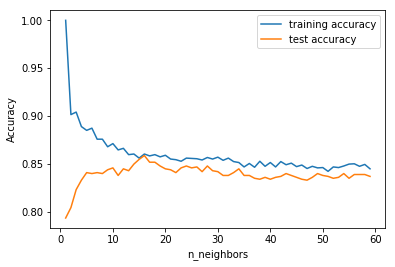

In [219]:
from sklearn.neighbors import KNeighborsClassifier

kn_training_accuracy = []
kn_test_accuracy = []
kn_range = range(1, 60)

for i in kn_range:
    kn = KNeighborsClassifier(n_neighbors=i)
    kn.fit(X_train, y_train)
    kn_training_accuracy.append(kn.score(X_train, y_train))
    kn_test_accuracy.append(kn.score(X_test, y_test))
    
plt.plot(kn_range, kn_training_accuracy, label="training accuracy")
plt.plot(kn_range, kn_test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

best_kn_accuracy = max(kn_test_accuracy)
best_kn_index = kn_test_accuracy.index(best_kn_accuracy)
best_kn = KNeighborsClassifier(n_neighbors=best_kn_index)
print(best_kn_accuracy)
print(kn_range[best_kn_index])

We see that the k nearest neighbor model achieves its best accuracy of 85.9% at 16 neighbors. More than that results in overfitting that degrades the model performance.

## Logistic regression

For logistic regression I will iterate over the possible values of C, the regularization strength. Another hyper parameter is the penalty, but I don't know enough about weather to make a decision in how relevant the features are.

0.8745059288537549
0.022


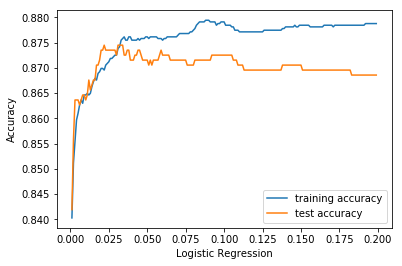

In [226]:
from sklearn.linear_model import LogisticRegression

lgr_training_accuracy = []
lgr_test_accuracy = []
lgr_range = [x/1000 for x in range(1, 200)]

for i in lgr_range:
    lgr = LogisticRegression(C=i, solver='liblinear')
    lgr.fit(X_train, y_train)
    lgr_training_accuracy.append(lgr.score(X_train, y_train))
    lgr_test_accuracy.append(lgr.score(X_test, y_test))
    
plt.plot(lgr_range, lgr_training_accuracy, label="training accuracy")
plt.plot(lgr_range, lgr_test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Logistic Regression")
plt.legend()

best_lgr_accuracy = max(lgr_test_accuracy)
best_lgr_index = lgr_test_accuracy.index(best_lgr_accuracy)
best_lgr = KNeighborsClassifier(n_neighbors=best_lgr_index)
print(best_lgr_accuracy)
print(lgr_range[best_lgr_index])

Testing with ranges between [0..100] yielded poor results, with training accuracy consistently above testing accuracy. Experimenting with fractional ranges gave better results, with C=0.022 giving the best test accuracy results.

One issue to note here is that for this case, the test accuracy is even better than the training accuracy, with should set off some alarm bells.

## Decision tree classifier

In this model we have direct control over the depth of the tree. We will iterate over it to see the optimal fitting point.

0.8567193675889329
4


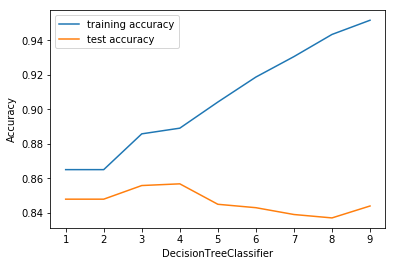

In [231]:
from sklearn.tree import DecisionTreeClassifier

dtc_training_accuracy = []
dtc_test_accuracy = []
dtc_range = range(1,10)
for i in dtc_range:
    dtc = DecisionTreeClassifier(max_depth = i)
    dtc.fit(X_train, y_train)
    dtc_training_accuracy.append(dtc.score(X_train, y_train))
    dtc_test_accuracy.append(dtc.score(X_test, y_test))
    
plt.plot(dtc_range, dtc_training_accuracy, label="training accuracy")
plt.plot(dtc_range, dtc_test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("DecisionTreeClassifier")
plt.legend()

best_dtc_accuracy = max(dtc_test_accuracy)
best_dtc_index = dtc_test_accuracy.index(best_dtc_accuracy)
best_dtc = KNeighborsClassifier(n_neighbors=best_dtc_index)
print(best_dtc_accuracy)
print(dtc_range[best_dtc_index])

From the graph we can see that the best accuracy score is achieved with a tree depth of 4. Any more than that results in overfitting.

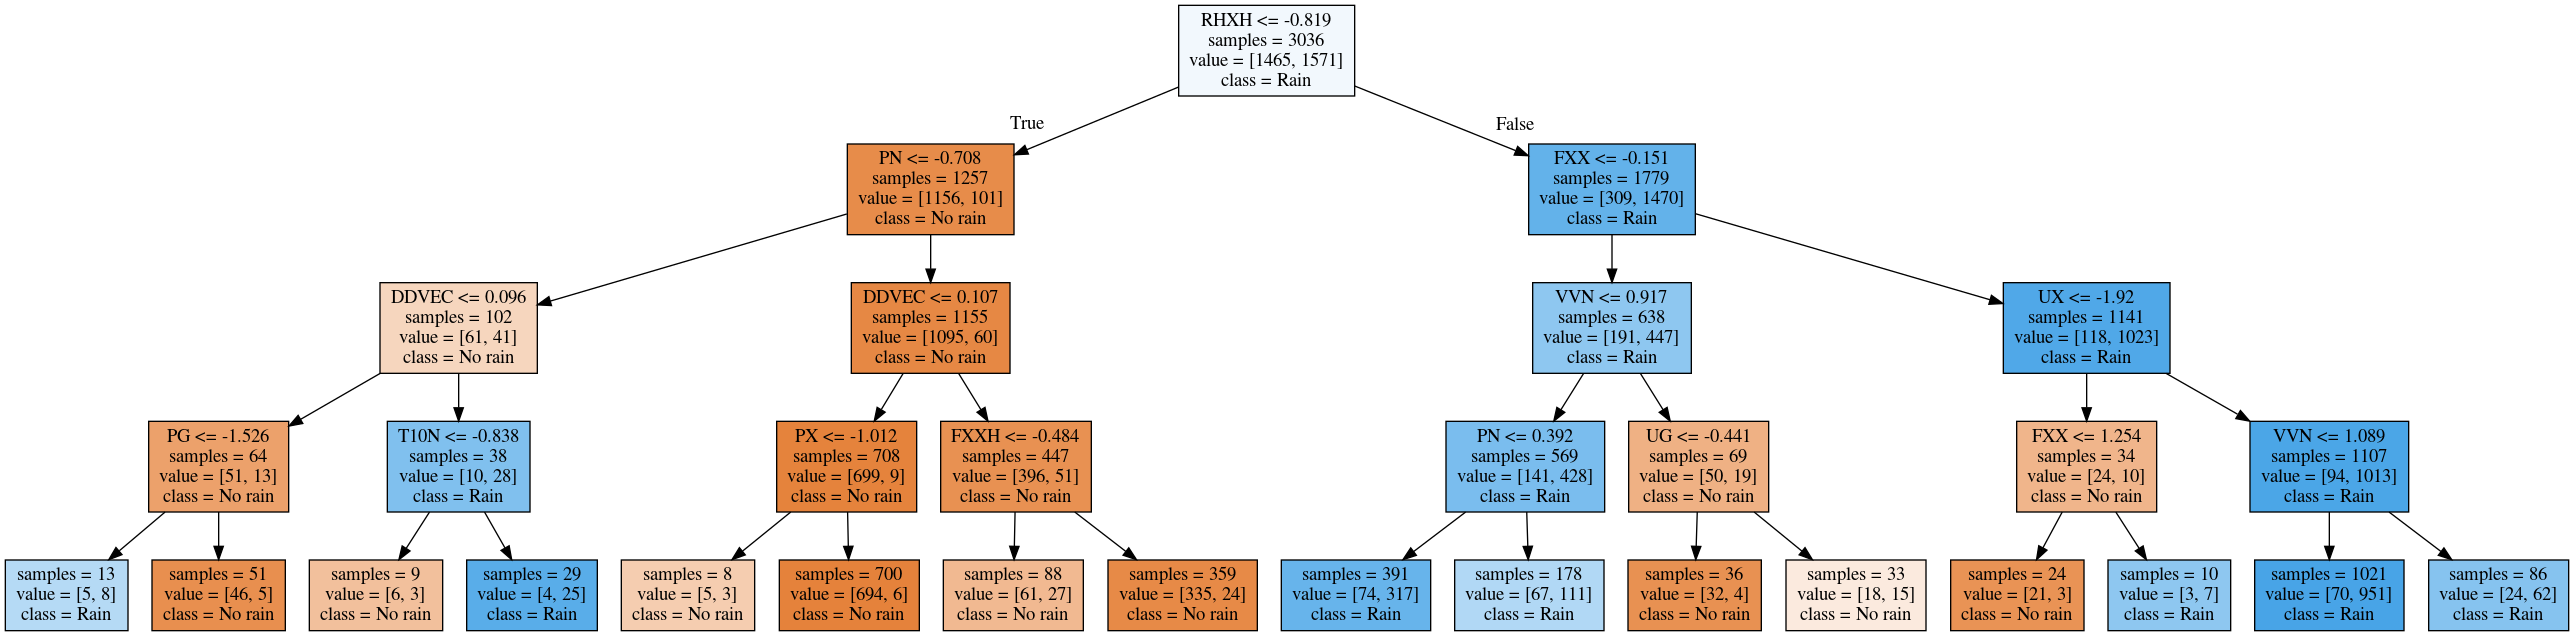

In [232]:
from sklearn.tree import export_graphviz
export_graphviz(final_dtc, out_file='dtc.dot', feature_names=features.columns,
                impurity=False, class_names=['No rain', 'Rain'], filled=True)
call(['dot', '-T', 'png', 'dtc.dot', '-o', 'dtc.png'])
Image('dtc.png')

## Random Forest classifier

This is the second method analyzed in class. 